In [1]:
import itertools
import pathlib
import pyam

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')

<IPython.core.display.Javascript object>

In [90]:
palette = {
    '1.5C': pyam.plotting.PYAM_COLORS["AR6-C1"],
    '1.5C-OS': pyam.plotting.PYAM_COLORS["AR6-C2"],
    '2C': pyam.plotting.PYAM_COLORS["AR6-C3"],
}

# Load Data

In [2]:
data_path = pathlib.Path('../data')

In [3]:
meta = pd.merge(
    pd.read_csv(data_path / 'gidden_et_al_2022_ar6_reanalysis_meta.csv'),
    pd.read_csv(data_path / 'additional_analysis_metadata.csv'),
    on=['model', 'scenario'], how='inner'
)

# Plot Utilities

In [8]:
variable_templates = [
    'AR6 climate diagnostics|Infilled|Emissions|{gas}', # as reported in AR6
    'AR6 Reanalysis|OSCARv3.2|Emissions|{gas}|Direct Only', # reanalyzed by OSCAR
    'AR6 Reanalysis|OSCARv3.2|Emissions|{gas}', # reanalyzed by OSCAR including NGHGI adjustment 
]

In [93]:
def figure_data(data, variable_start, gas, name):
    print(name)
    cols = [variable_start + template.format(gas=gas) for template in variable_templates]
    headers = ['AR6 Statistics', 'Pathways with OSCAR Direct Effects', 'Pathways with OSCAR Direct & Indirect Effects']
    for col in cols:
        if not col in data:
            raise ValueError(f'{col} not in data columns')
    ret = (
        data
        .query("Category in ['C1', 'C2', 'C3']")
        .replace({'Category': {'C1': '1.5C', 'C2': '1.5C-OS', 'C3': '2C'}})
        .rename(columns={c: h for c, h in zip(cols, headers)})
        [headers + ['Category']]
    )
    ret = (
        ret
        .dropna()
        .sort_values(by='AR6 Statistics', ascending=True)
        .reset_index(drop=True)
        .reset_index()
    )
    return ret

In [94]:
def scatter_compare(data, right='Pathways with OSCAR Direct Effects', left="Pathways with OSCAR Direct & Indirect Effects"):
    fig, ax = plt.subplots(figsize=(6, 8))
    hue = 'Category'
    sns.scatterplot(
        data=data, 
        x=right, y="index", hue=hue, palette=palette,
        label=right,
        marker='o', size=2, edgecolor='white', linewidths=0.05, 
        ax=ax, 
    )
    sns.scatterplot(
        data=data, 
        x=left, y="index", hue=hue, palette=palette,
        label=left,
        marker='^', size=2,  edgecolor='k', linewidths=0.05, 
        ax=ax,
    )
    ax.get_yaxis().set_visible(False)
    ax.set_xlabel('')
    h, l = ax.get_legend_handles_labels()
    idx = 2 + len(data[hue].unique())
    ax.legend(h[::5], l[::5], **pyam.plotting.OUTSIDE_LEGEND['right'])

    return fig, ax

# Cumulative CO2

Carbon Budget from 2020


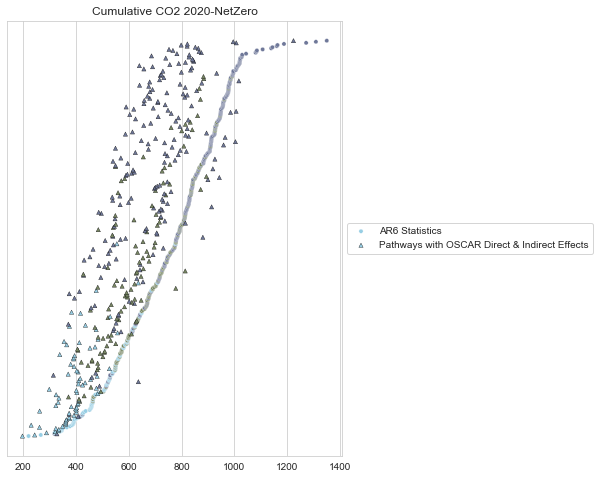

In [104]:
data = figure_data(meta, 'Carbon Budget for ', 'CO2', 'Carbon Budget from 2020')
fig, ax = scatter_compare(data, right='AR6 Statistics', left='Pathways with OSCAR Direct & Indirect Effects')
ax.set_title('Cumulative CO2 2020-NetZero')
fig.savefig('./files/fig2a1.pdf', bbox_inches='tight')

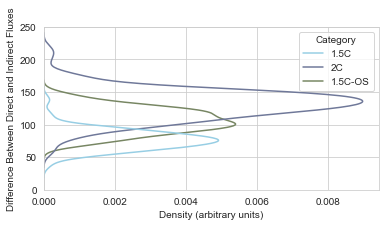

In [105]:
label = 'Difference Between Direct and Indirect Fluxes'
diff = data['Pathways with OSCAR Direct Effects'] - data['Pathways with OSCAR Direct & Indirect Effects']
data[label] = diff

fig, ax = plt.subplots(figsize=(6, 3))
sns.kdeplot(data=data, y=label, hue="Category", palette=palette, multiple="layer", ax=ax)
ax.set_xlabel('Density (arbitrary units)')
ax.set_ylim((0, 250))
#ax.legend(**pyam.plotting.OUTSIDE_LEGEND['right'])

fig.savefig('./files/fig2a2.pdf', bbox_inches='tight')

# Net-zero Year

Net-zero CO2 Year


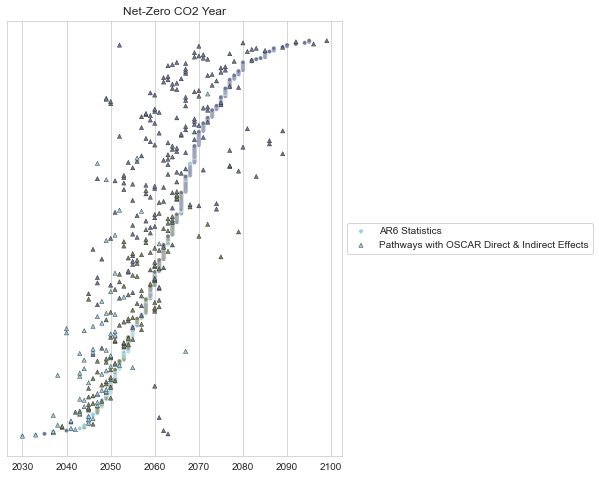

In [109]:
data = figure_data(meta, 'Interpolated Net-Zero Year for ', 'CO2', 'Net-zero CO2 Year')
fig, ax = scatter_compare(data, right='AR6 Statistics', left='Pathways with OSCAR Direct & Indirect Effects')
ax.set_title('Net-Zero CO2 Year')

fig.savefig('./files/fig2b1.pdf', bbox_inches='tight')

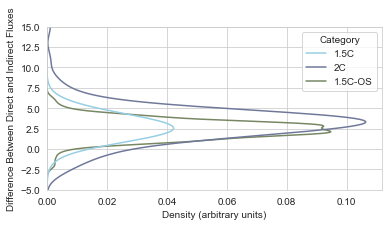

In [107]:
label = 'Difference Between Direct and Indirect Fluxes'
diff = data['Pathways with OSCAR Direct Effects'] - data['Pathways with OSCAR Direct & Indirect Effects']
data[label] = diff

fig, ax = plt.subplots(figsize=(6, 3))
sns.kdeplot(data=data, y=label, hue="Category", palette=palette, multiple="layer", ax=ax)
ax.set_xlabel('Density (arbitrary units)')
ax.set_ylim((-5, 15))

fig.savefig('./files/fig2b2.pdf', bbox_inches='tight')